In [ ]:
!pip install gdown
!gdown --id '1ZHiWbLZvraM6tyZx4s9ZuNT1IvjxHb-3' --output Face.zip
!unzip Face.zip

In [ ]:
!git clone https://github.com/kipr/opencv

In [ ]:
!pip install transformers==4.5.0

In [ ]:
import numpy as np

import torch
import torchvision
from torchvision.transforms import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import ConcatDataset, DataLoader
from torchvision.datasets import DatasetFolder, ImageFolder

from transformers import get_linear_schedule_with_warmup

In [ ]:
def crop_face(tensor_img):
  img = np.asarray(transforms.ToPILImage()(tensor_img))
  faces = face_cascade.detectMultiScale(image = img, scaleFactor = 1.01, minNeighbors = 3)

  if len(faces) > 1:
    max_area, index = 0,0
    for i in range(len(faces)):
      if faces[i][2]*faces[i][3] > max_area:
        max_area, index = faces[i][2]*faces[i][3], i
    faces = np.expand_dims(faces[index], axis=0)

  for (x, y, w, h) in faces:
      cv2.rectangle(img, (x, y), (x+w, y+h), (0, 0, 0), -1)
      
  return torch.tensor(img).permute(2, 0, 1)

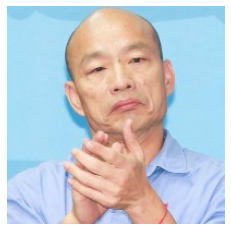

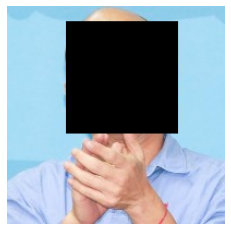

In [ ]:
import cv2

face_cascade = cv2.CascadeClassifier('./opencv/data/haarcascades/haarcascade_frontalface_default.xml')

img = cv2.imread('./Face/A_Face/A_cropped/1563164911-9bd7b2224cec3f3a154b52247dfd6c83-696x463_cropped.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
plt.axis("off")
plt.show()

faces = face_cascade.detectMultiScale(image = img, scaleFactor = 1.1, minNeighbors = 7)

for (x, y, w, h) in faces:
      cv2.rectangle(img, (x, y), (x+w, y+h), (0, 0, 0), -1)

plt.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2BGR)) 
plt.axis("off")
plt.show()

In [ ]:
train_tfm = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
])

train_flip_tfm = transforms.Compose([
    transforms.RandomHorizontalFlip(p=1),
    transforms.Resize((64,64)),
    transforms.ToTensor(),
])

addition_tfm = transforms.Compose([
    torchvision.transforms.RandomAffine(degrees=30, shear=(0,15))
])

In [ ]:
A_train_set = ImageFolder("./Face/A_Face", loader=lambda x: Image.open(x), transform=train_tfm)
A_train_flip_set = ImageFolder("./Face/A_Face", loader=lambda x: Image.open(x), transform=train_flip_tfm)
A_train_set = ConcatDataset([A_train_set, A_train_flip_set])
A_train_loader = DataLoader(A_train_set, batch_size=1, shuffle=True, pin_memory=True, num_workers=2)

In [ ]:
len(A_train_loader)

102

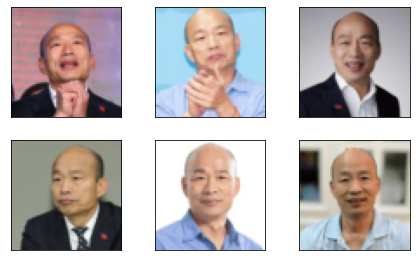

In [ ]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(transforms.ToPILImage()(A_train_set[i][0]))
  plt.xticks([])
  plt.yticks([])

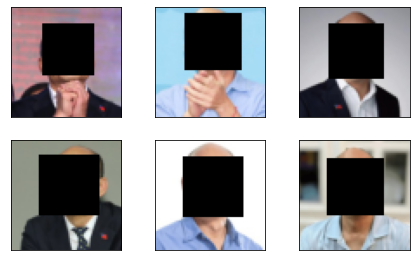

In [ ]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(transforms.ToPILImage()(crop_face(A_train_set[i][0])))
  plt.xticks([])
  plt.yticks([])

In [ ]:
B_train_set = ImageFolder("./Face/B_Face", loader=lambda x: Image.open(x), transform=train_tfm)
B_train_flip_set = ImageFolder("./Face/B_Face", loader=lambda x: Image.open(x), transform=train_flip_tfm)
B_train_set = ConcatDataset([B_train_set, B_train_flip_set])
B_train_loader = DataLoader(B_train_set, batch_size=1, shuffle=True, pin_memory=True, num_workers=2)

In [ ]:
len(B_train_loader)

102

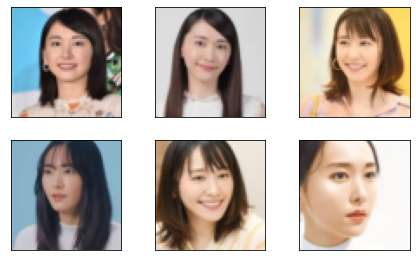

In [ ]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(transforms.ToPILImage()(B_train_set[i][0]))
  plt.xticks([])
  plt.yticks([])

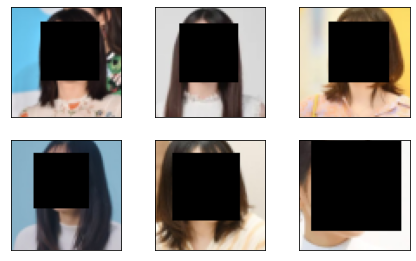

In [ ]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(transforms.ToPILImage()(crop_face(B_train_set[i][0])))
  plt.xticks([])
  plt.yticks([])

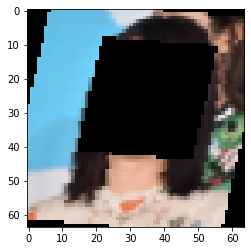

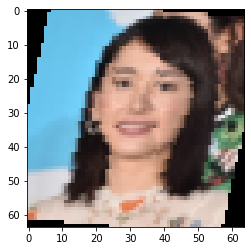

In [ ]:
torch.random.manual_seed(6)
plt.imshow(transforms.ToPILImage()(addition_tfm(crop_face(B_train_set[0][0]))))
plt.show()
torch.random.manual_seed(6)
plt.imshow(transforms.ToPILImage()(addition_tfm(B_train_set[0][0])))
plt.show()

In [ ]:
class conv_autoencoder(nn.Module):
    def __init__(self):
        super(conv_autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32*4, 4, stride=2, padding=1), 
            nn.BatchNorm2d(32*4),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Conv2d(32*4, 64*4, 4, stride=2, padding=1), 
            nn.BatchNorm2d(64*4),
            nn.Dropout(0.2),  
            nn.ReLU(),
            nn.Conv2d(64*4, 128*4, 4, stride=2, padding=1),  
            nn.BatchNorm2d(128*4),
            nn.Dropout(0.2), 
            nn.ReLU(),
            nn.Conv2d(128*4, 256*4, 1, stride=1, padding=0),  
            nn.BatchNorm2d(256*4),
            nn.Dropout(0.2),  
            nn.ReLU(),

        )
        self.a_decoder = nn.Sequential(
            nn.Conv2d(256*4, 128*4, 1, stride=1, padding=0),  
            nn.BatchNorm2d(128*4), 
            nn.ReLU(),
            nn.ConvTranspose2d(128*4, 64*4, 4, stride=2, padding=1), 
            nn.BatchNorm2d(64*4),
            nn.ReLU(),
            nn.ConvTranspose2d(64*4, 32*4, 4, stride=2, padding=1), 
            nn.BatchNorm2d(32*4),
            nn.ReLU(),
            nn.ConvTranspose2d(32*4, 3, 4, stride=2, padding=1),
            nn.Tanh()
        )
        self.b_decoder = nn.Sequential(
            nn.Conv2d(256*4, 128*4, 1, stride=1, padding=0),  
            nn.BatchNorm2d(128*4), 
            nn.ReLU(),
            nn.ConvTranspose2d(128*4, 64*4, 4, stride=2, padding=1), 
            nn.BatchNorm2d(64*4),
            nn.ReLU(),
            nn.ConvTranspose2d(64*4, 32*4, 4, stride=2, padding=1), 
            nn.BatchNorm2d(32*4),
            nn.ReLU(),
            nn.ConvTranspose2d(32*4, 3, 4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x, Type=None):
        x = self.encoder(x)
        if Type == "A":
          x = self.a_decoder(x)
        elif Type == "B":
          x = self.b_decoder(x)
        return x

In [ ]:
num_epochs = 2000

# Warm up
warm_up_ratio = 0.1
step = len(A_train_loader)
total_step = num_epochs * step

model = conv_autoencoder()
model.cuda()

A_optimizer = torch.optim.RAdam([
                {'params': model.encoder.parameters()},
                {'params': model.a_decoder.parameters()}
                ], lr=1e-4, weight_decay=0)
B_optimizer = torch.optim.RAdam([
                {'params': model.encoder.parameters()},
                {'params': model.b_decoder.parameters()}
                ], lr=1e-4, weight_decay=0)

A_scheduler = get_linear_schedule_with_warmup(A_optimizer, num_warmup_steps = warm_up_ratio * total_step, num_training_steps = total_step)
B_scheduler = get_linear_schedule_with_warmup(B_optimizer, num_warmup_steps = warm_up_ratio * total_step, num_training_steps = total_step)

In [ ]:
seed = 0
best_loss = np.inf
model.train()

for epoch in range(num_epochs):

    tot_loss = list()
    # Train A face
    for data, _ in A_train_loader:
        # ===================loading=====================
        torch.random.manual_seed(seed)
        img = addition_tfm(data).cuda()
        torch.random.manual_seed(seed)
        crop_img = addition_tfm(crop_face(data[0])).cuda()
        # ================A face forward===============
        output = model(torch.unsqueeze(crop_img.float(), 0), "A")
        loss = F.mse_loss(output, img)
        tot_loss.append(loss.item())
        # ===================backward====================
        A_optimizer.zero_grad()
        loss.backward()
        A_optimizer.step()
        A_scheduler.step()
        seed += 1

    # Train B face
    for data, _ in B_train_loader:
        # ===================loading=====================
        torch.random.manual_seed(seed)
        img = addition_tfm(data).cuda()
        torch.random.manual_seed(seed)
        crop_img = addition_tfm(crop_face(data[0])).cuda()
        # ================B face forward===============
        output = model(torch.unsqueeze(crop_img.float(), 0), "B")
        loss = F.mse_loss(output, img)
        tot_loss.append(loss.item())
        # ===================backward====================
        B_optimizer.zero_grad()
        loss.backward()
        B_optimizer.step()
        B_scheduler.step()
        seed += 1
        
    # ===================save_best====================
    mean_loss = np.mean(tot_loss)
    if mean_loss < best_loss:
        best_loss = mean_loss
        torch.save(model, 'best_model_cnn.pt')
    # ===================log========================
    print(f"Epoch {epoch + 1:.0f}/{num_epochs:.0f} | loss = {mean_loss:.7f}")

Epoch 1/2000 | loss = 0.7315339
Epoch 2/2000 | loss = 0.7218007
Epoch 3/2000 | loss = 0.7045885
Epoch 4/2000 | loss = 0.6757227
Epoch 5/2000 | loss = 0.6340863
Epoch 6/2000 | loss = 0.5759448
Epoch 7/2000 | loss = 0.4996656
Epoch 8/2000 | loss = 0.4172189
Epoch 9/2000 | loss = 0.3400433
Epoch 10/2000 | loss = 0.2861391
Epoch 11/2000 | loss = 0.2531075
Epoch 12/2000 | loss = 0.2324867
Epoch 13/2000 | loss = 0.2153610
Epoch 14/2000 | loss = 0.1990210
Epoch 15/2000 | loss = 0.1844192
Epoch 16/2000 | loss = 0.1715635
Epoch 17/2000 | loss = 0.1579115
Epoch 18/2000 | loss = 0.1448717
Epoch 19/2000 | loss = 0.1324169
Epoch 20/2000 | loss = 0.1249292
Epoch 21/2000 | loss = 0.1174539
Epoch 22/2000 | loss = 0.1110960
Epoch 23/2000 | loss = 0.1027887
Epoch 24/2000 | loss = 0.0932232
Epoch 25/2000 | loss = 0.0858052
Epoch 26/2000 | loss = 0.0806276
Epoch 27/2000 | loss = 0.0749284
Epoch 28/2000 | loss = 0.0690037
Epoch 29/2000 | loss = 0.0623695
Epoch 30/2000 | loss = 0.0589958
Epoch 31/2000 | los

In [ ]:
# load trained model
checkpoint_path = 'best_model_cnn.pt'
model = torch.load(checkpoint_path)
model.eval()

conv_autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): ReLU()
    (4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.2, inplace=False)
    (7): ReLU()
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Dropout(p=0.2, inplace=False)
    (11): ReLU()
    (12): Conv2d(512, 1024, kernel_size=(1, 1), stride=(1, 1))
    (13): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): Dropout(p=0.2, inplace=False)
    (15): ReLU()
  )
  (a_decoder): Sequential(
    (0): Conv2d(1024, 512, kernel_size=(1, 1), s

Before


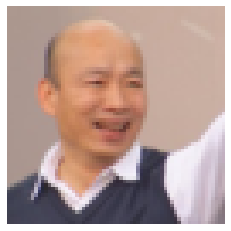

Cropped


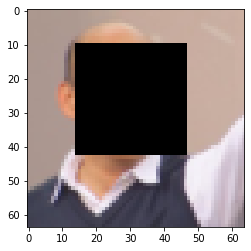

After


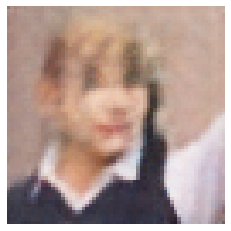

Before


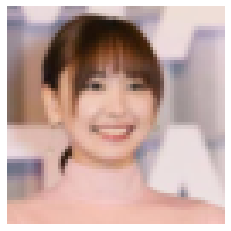

Cropped


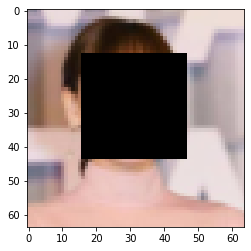

After


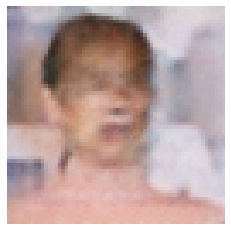

In [ ]:
# Show images
def show_images(images):
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    for index, image in enumerate(images):
        plt.subplot(sqrtn, sqrtn, index+1)
        plt.imshow(transforms.ToPILImage()(image))
        plt.axis('off')


with torch.no_grad():
  for data, target in A_train_loader:
     
        img = data.cuda()
        crop_img = crop_face(data[0]).cuda()
        output = model(torch.unsqueeze(crop_img.float(), 0), "B")

        print('Before')
        show_images(img[:16])
        plt.show()

        print('Cropped')
        plt.imshow(transforms.ToPILImage()(crop_img))
        plt.show()

        print('After')
        show_images(output[:16])
        plt.show()
        break

with torch.no_grad():
  for data, target in B_train_loader:
    
        img = data.cuda()
        crop_img = crop_face(data[0]).cuda()
        output = model(torch.unsqueeze(crop_img.float(), 0), "A")

        print('Before')
        show_images(img[:16])
        plt.show()

        print('Cropped')
        plt.imshow(transforms.ToPILImage()(crop_img))
        plt.show()

        print('After')
        show_images(output[:16])
        plt.show()
        break